In [14]:
from sympy import S
from sympy.physics.wigner import clebsch_gordan
from sympy.physics.wigner import racah
from sympy.physics.wigner import wigner_3j
from sympy.physics.wigner import wigner_6j
import numpy as np
from __future__ import division
import scipy as sci
import scipy.special as sp
from scipy.integrate import dblquad
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from scipy.stats import qmc
import os
import datetime
import time
import scipy.stats as sps
from multiprocessing import Pool
from itertools import repeat
import random
import math
from scipy.integrate import odeint
from IPython.display import display, clear_output,set_matplotlib_formats
import matplotlib.cm as cm
import matplotlib.ticker
import matplotlib.mlab as mlab
import sys
from scipy.stats import norm

#plt.style.use('science')
plt.rcParams.update({'font.size': 12})
gr = 4
h = 3

In [15]:
import numpy as np
from scipy.integrate import tplquad

l_deform = 2
m_deform = 0
energy = 100
beta2 = 1.3
mass_target = 58.268
mass_coeff = mass_target**(1/3)

r_array = np.linspace(0, 20, 1000)

R0 = 1.2*mass_coeff

a0 =0.65

V0 = 40.0

hbarc = 197 # MeV • fm

def wood_saxon_potential_deformed(r, theta, phi):
    '''
    From the previously defined angular momentum components of the deformation introduce a deformation
    parametrized by  "beta2"
    '''
    R = R0 - beta2*(sp.sph_harm(m_deform, l_deform, phi, theta))
    return - V0 / (1 + np.exp((r - R) / a0))

# Constants or parameters
R_max = 10.0  # Maximum radial distance for integration
num_points = 500  # Number of points for integration

# Define the integrand for the numerator and denominator
def integrand_numerator(r, theta, phi):
    return r * abs(wood_saxon_potential_deformed(r, theta, phi))**2 * np.sin(theta)

def integrand_denominator(r, theta, phi):
    return abs(wood_saxon_potential_deformed(r, theta, phi))**2 * np.sin(theta)

# Perform the triple integral using scipy's tplquad
numerator, _ = tplquad(integrand_numerator, 0, R_max, lambda phi: 0, lambda phi: 2*np.pi,
                       lambda theta, phi: 0, lambda theta, phi: np.pi)

denominator, _ = tplquad(integrand_denominator, 0, R_max, lambda phi: 0, lambda phi: 2*np.pi,
                         lambda theta, phi: 0, lambda theta, phi: np.pi)

# Calculate the average radius
R_avg = numerator / denominator

print("Average Radius of Deformation:", R_avg)


Average Radius of Deformation: 1.900390017540925


In [16]:
def wood_saxon_potential_rescaled(r,theta,phi):
    R = R0 - beta2*(sp.sph_harm(m_deform, l_deform, phi, theta))+(beta2**2)/(4*np.pi*R_avg)
    return - V0 / (1 + np.exp((r - R) / a0))

In [17]:
# Create a grid of points in 3D space
r = np.linspace(0, 20, 1000)
theta = np.linspace(0, np.pi, 100)
phi = np.linspace(0, 2 * np.pi, 200)
r, theta, phi = np.meshgrid(r, theta, phi)

# Calculate the potential energy at each point in the grid (check that this works)
potential = wood_saxon_potential_rescaled(r, theta, phi)


In [18]:
# Calculate the multipole moments using spherical harmonics
def calculate_multipole_moments(l_max, r_values):
    moments = {}
    '''
    Equation () of the report. Integrate out the angular dependencies of the spherical harmonics to obtain the 
    radial deformation. As inputs, the maximum multipole moment integrated and the radial grid of the interaction.
    The outputs will be the radial functions for each degree of multipole being integrated, as a dictionary. 
    '''
    for l in range(l_max + 1):
        for m in range(1):
            #for m in range(-l, l + 1):
            values = []
            for r in r_values:
                integrand_real = lambda theta, phi: wood_saxon_potential_rescaled(r, theta, phi).real * sp.sph_harm(m, l, phi, theta).real * np.sin(theta)/(np.pi)*np.sqrt(np.pi/4)#*0.5/(2*np.pi)#*norm#*(4*np.pi)**(-1)*(2*l+1)**(1/2)
                integrand_imag = lambda theta, phi: wood_saxon_potential_rescaled(r, theta, phi).imag * sp.sph_harm(m, l, phi, theta).imag * np.sin(theta)/(np.pi)*np.sqrt(np.pi/4)#*0.5/(2*np.pi)#*norm#*(4*np.pi)**(-1)*(2*l+1)**(1/2)
                result_real, _ = dblquad(integrand_real, 0, 2 * np.pi,lambda theta: 0, lambda theta: np.pi)
                result_imag, _ = dblquad(integrand_imag, 0, 2 * np.pi,lambda theta: 0, lambda theta: np.pi)
                values.append(result_real+1j*result_imag)
            moments[(l, m)] = (values)
            
    return moments

In [19]:
#run the integral function for a l_max and radial array
multipole_moments = calculate_multipole_moments(l_max=5, r_values=r_array)

#extract the radial functions with different multipole moments
V_mono = multipole_moments.get((0,0))
V_dip = multipole_moments.get((1,0))
V_quad = multipole_moments.get((2,0))
V_oct = multipole_moments.get((3,0))
V_ten = multipole_moments.get((4,0))

<function matplotlib.pyplot.show(close=None, block=None)>

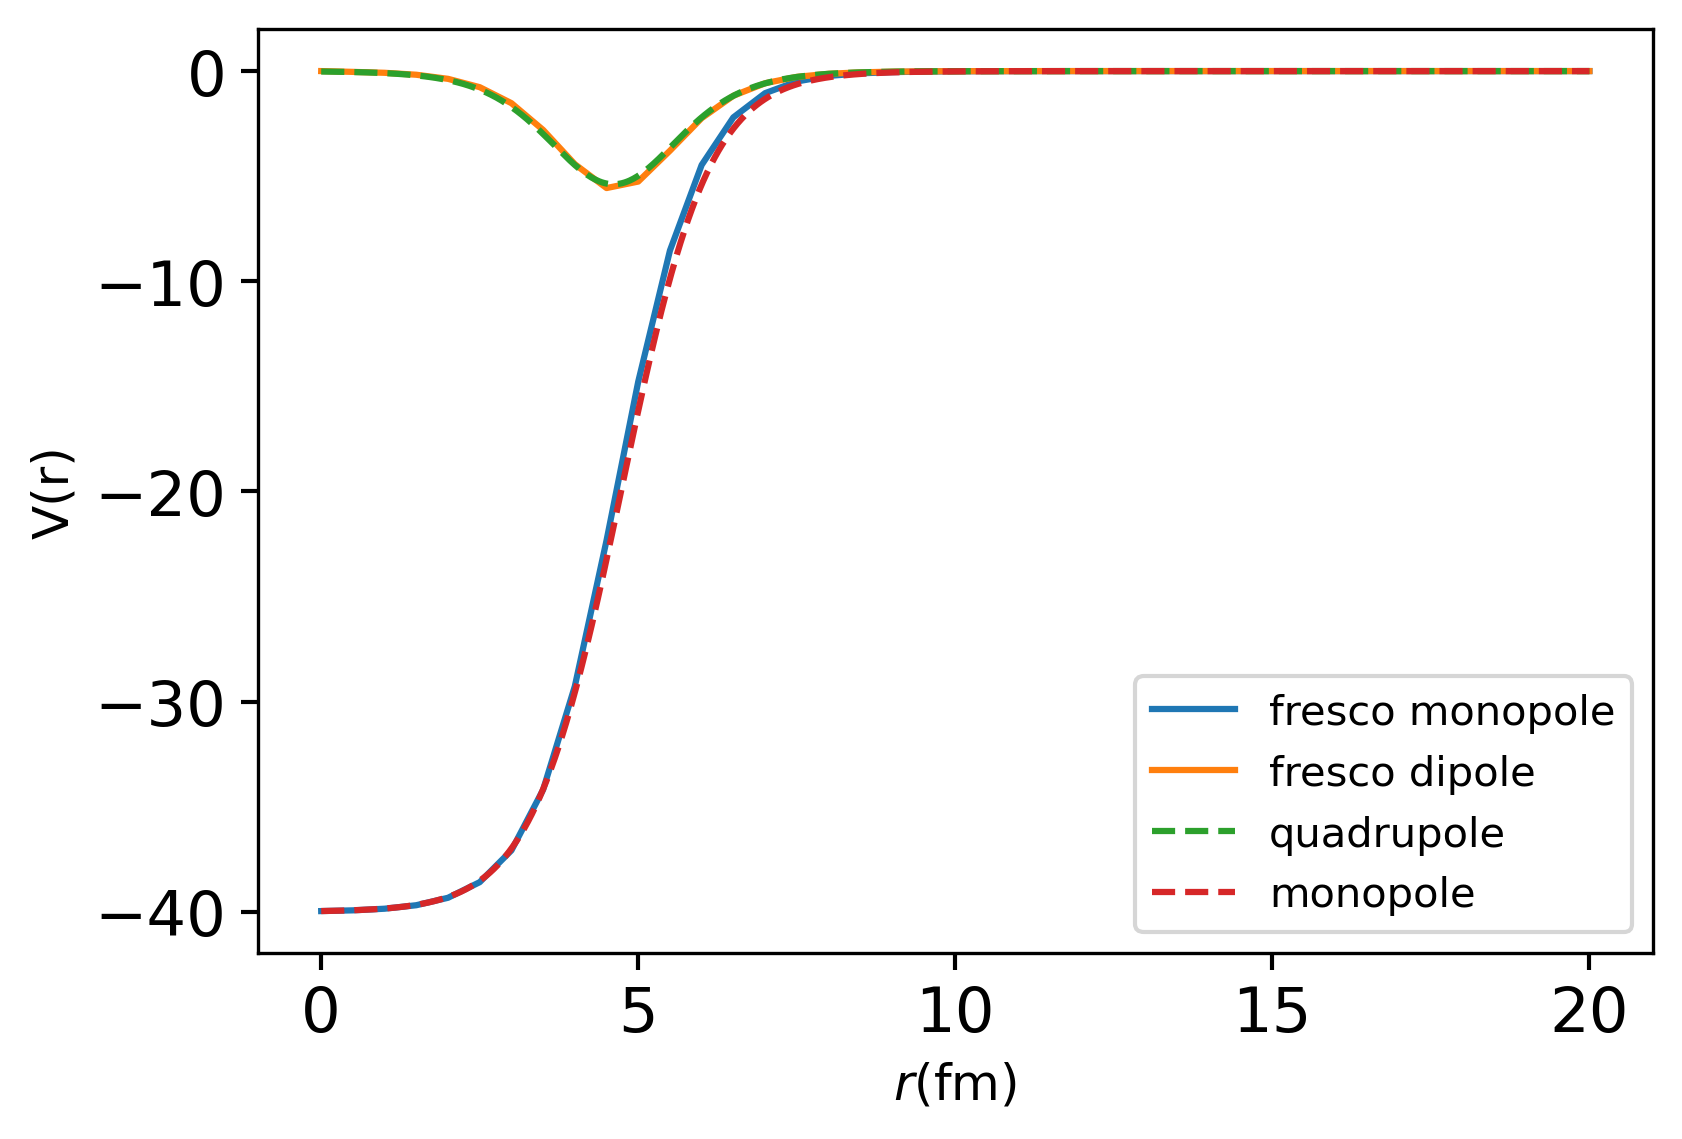

In [20]:
fig, ax = plt.subplots(figsize=(6,4),dpi=300)
fig.patch.set_facecolor('white')

matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['legend.fontsize'] = 10
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15

r_grid = np.linspace(0,20,1000)



#read in the monopole term from fresco   
x1 = []
y1 = []
f = open("monopole.txt")
for line in f:
    line = line.strip().split() 
    x1.append(float(line[0]))
    y1.append(float(line[1]))



#read in quadrupole term from fresco    
x2 = []
y2 = []
f = open("quadrupole.txt")
for line in f:
    line = line.strip().split() 
    x2.append(float(line[0]))
    y2.append(float(line[1]))

#compare to the ones extracted through the integral


ax.plot(x1,y1,label='fresco monopole')
ax.plot(x2,y2,label='fresco dipole')
ax.plot(r_grid,-np.abs(V_quad),linestyle='--',label='quadrupole')
ax.plot(r_grid,-np.abs(V_mono),linestyle='--',label='monopole')

#ax.set_yscale('log')
ax.set_xlabel(r'$r$(fm)')
ax.set_ylabel(r'V(r)')
ax.tick_params(width=1, length=4)
ax.legend()
fig.savefig(str("Fresco_comparison.png"))
plt.show